## CS 401 Applied Data Analysis, 2018 autumn
## Final Project: Exploration on Media polarity in the News
##### Group Members: Ruibin Huang, Liangwei Chen, Fengyu Cai

### Objective:
In this project, we would like to dig up the potential media polarity about the news on the websites. Through the year, we hope to find out the bias for some media as to some specific topics.

### Main Step
- Label the news with keywords or topic
    - TF-IDF
- Select specific news and medias for analysis in the similar time and topic
    - NLTK sentiment analysis package
- Further analyze based on the chronological and geometrical features of the medias
    - map or plot

Technologies applied (and will be applied): spark, Machine Learning, NLTK, Web Crawling

### About Datasets:
1. News Source: containing News IDs, Publisher, Publish Date, Publish Region, Publish Organization, News URL and News Title
2. News Excerpt: containing excerpts of website HTML, responding to the NEWs ID.
3. News parse and stemming: containing the canonical steming form of the news, which is convenient for manipulation and search.

### Milestone Summary:
In this milestone, we will do the analysis based on a limited data set: news on the website mainly during August, September, and October in 2016 in the United States.

And the whole process has been divided to four parts:
1. Get and clean the data
2. Topic Selection: from News parse and stemming file, we applied TF-IDF to choose the linguitics keyword as document feature.
3. Web Crawling: attempted to get the full text from the original websites.
3. Sentimental Analysis: analyze the polarity of the media on the selected topic in one month. Then, we further extended the range to three months in order to illustrate the time variance of media polarity.

In [414]:
# Import Module
import sys
import os
import re
import gc
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

# For the Topic-selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# For Website Crawling
from bs4 import BeautifulSoup
import requests

# For Sentimental Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob

### Part 1: Preprocess Data

In [603]:
# data path
stm_file = '16-10-us.txt'
alter_file = '16-10-us-clean.txt'
src_file = 'now_sources_pt2.txt'
txt_file = '16-10-us-txt.txt'
src_folder = 'source'

##### 1.1 Stemming File Clean:
As we find in the News Stemming File, there exits some illegal characters, therefore, we need to filter to get the pure data.

1.1.1 Encoding Issue

In [3]:
# remove the punctuations in the text, and replace them to N/A
with open(stm_file, 'r', errors='replace', encoding='utf-8') as f:
    with open(alter_file ,'w') as w:
        w.write(re.sub('\t[' + string.punctuation + ']\t', '\tN/A\t', f.read()))

1.1.2 Select the write format data

In [4]:
id_c = re.compile(r'\d+')
getId = lambda line: id_c.match(line).group(0)

In [115]:
colnames=['doc_id', 'word_id', 'word', 'origin_word', 'pos'] 
stemming_pd = pd.read_csv(alter_file, sep='\t', error_bad_lines=False, engine='python', header=None, names=colnames)

In [6]:
# the stemmed result
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
0,14637197,4739839025,@@14637197,NaN,fo
1,14637197,4739839026,<p>,NaN,null
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
4,14637197,4739839029,NaN,NaN,(
5,14637197,4739839030,AP,ap,np1
6,14637197,4739839031,NaN,NaN,)
7,14637197,4739839032,--,NaN,jj_nn1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1


In [7]:
# remove N/A (including punctuations)
stemming_pd.dropna(inplace=True)

In [8]:
# after drop NA
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
5,14637197,4739839030,AP,ap,np1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1
10,14637197,4739839035,'s,'s,ge
11,14637197,4739839036,five-day,five-day,jj
12,14637197,4739839037,feud,feud,nn1
13,14637197,4739839038,with,with,iw
14,14637197,4739839039,a,a,at1


In [9]:
# cleaned text by eliminating punctuations and illegal characters
stemming_list = stemming_pd.groupby('doc_id')['origin_word'].apply(list).apply(lambda x: ' '.join(x))

In [10]:
pd.DataFrame(stemming_list).head()

,origin_word
doc_id,
14637197,new york ap donald trump 's five-day feud with...
14637200,here be all the crazy stuff that happen at the...
14637201,another hotel want to build in the heart of ho...
14637202,in this sept 23 2016 photo rick retail sales m...
14637203,court erase jury award of punitive damage agai...


##### 1.2 Load the data Source

1.2.1 load new source data

In [11]:
new_src = pd.read_csv(os.path.join(src_folder, src_file), delimiter="\t", header=None, encoding = "ISO-8859-1")

In [12]:
new_src.columns=['id','unknown','date','country','media','website','title']

In [596]:
new_src.head(3)

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01


1.2.2 Data filtering and selection

In [14]:
new_src['year'], new_src['month'], new_src['day'] = new_src['date'].str.split('-', 2).str

In [191]:
new_src.head(3)

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01


In [16]:
new_src_us = new_src[new_src['country'] == 'US']

In [18]:
data_US_16_10 = new_src_us[(new_src_us['year'] == '16') & (new_src_us['month'] == '10')]

In [27]:
data_US_16_10_sorted = data_US_16_10.sort_values(by = 'id')

In [192]:
data_US_16_10_sorted.head(3)

,id,unknown,date,country,media,website,title,year,month,day
304572,14637197,170,16-10-01,US,Bristol Herald Courier (press release) (blog),http://www.heraldcourier.com/news/trump-s-habi...,Trump's habit of fuming over slights comes at ...,16,10,01
304573,14637200,411,16-10-01,US,CBSSports.com,http://www.cbssports.com/college-football/news...,Here's all the crazy stuff that happened at th...,16,10,01
304574,14637201,159,16-10-01,US,Curbed LA,http://la.curbed.com/2016/9/30/13128220/hollyw...,11 story hotel proposed for the heart of Holly...,16,10,01


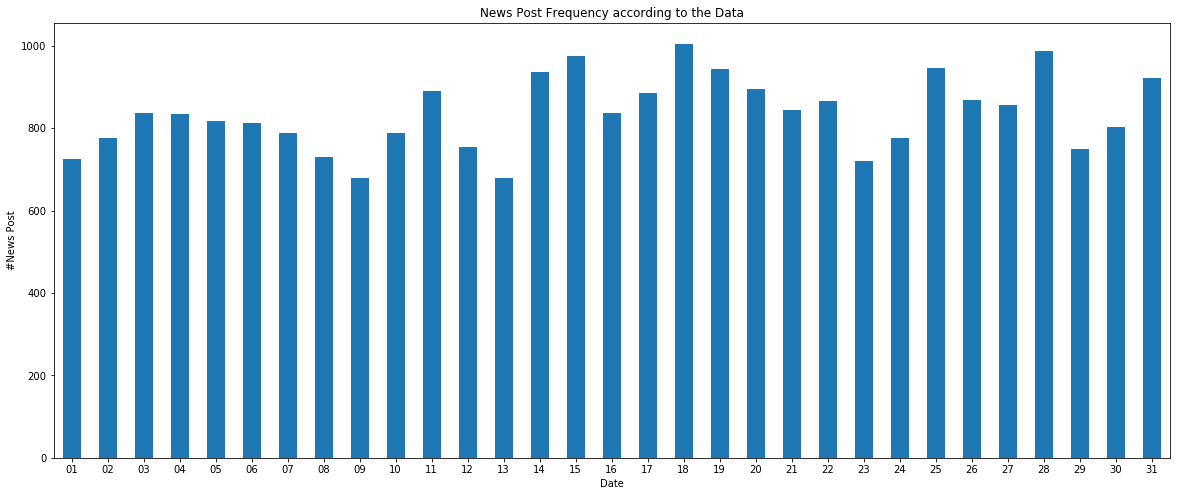

In [602]:
data_US_16_10_sorted['day'].value_counts().sort_index().plot.bar()
plt.title('News Post Frequency according to the Data')
plt.ylabel('#News Post')
plt.xlabel('Date')
plt.xticks(rotation=0)
plt.show()

##### 1.3 Load text of news

1.3.1 load the file

In [173]:
with open(txt_file, 'r') as f:
    txt = f.read()

In [178]:
# show the text content
txt[:1500]

'@@14637197 <p> NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost . <p> The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . " <h> Subscription Required <p> An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety . <p> Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an onlin

1.3.2 Data formalization and cleaning

In [179]:
# re object defination
# get ID
id_tag = re.compile('\@\@([0-9]{8})')

# remove <p>, <p>
tagger = re.compile(r'\<.{1,2}\>')

In [242]:
# generator of the id_tag
iterpnt = id_tag.finditer(txt)
txt_dict = {}

In [243]:
# get id regexp object list
pnt_list = [pnt for pnt in iterpnt]

# get the text responding to news id
for i in range(1, len(pnt_list)+1):
    if i < len(pnt_list):
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:pnt_list[i].span()[0]])
    else:
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:])

In [422]:
# transform to DataFrame
txt_pd = pd.DataFrame(pd.Series(txt_dict, name='txt'))
txt_pd.head(5)

,txt
14637197,NEW YORK ( AP ) -- Donald Trump 's five-day ...
14637200,Here 's all the crazy stuff that happened at...
14637201,Another hotel wants to build in the heart of...
14637202,"In this Sept. 23 , 2016 photo , Rick Wollum ..."
14637203,Court erases jury award of punitive damages ...


In [245]:
# show the transformed content of an article
txt_pd['txt'][0]

'  NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost .  The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . "  Subscription Required  An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety .  Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an online service to @ @ @ @ @ @ 

### Part 2: Select Topic

After data processing, we step to the next step of topic selection. We will use the methods of TF-IDF, which has been embeded in skicit-learn.

##### 2.1 Get the word frequency

In [30]:
# In the milestone, we only consider 1-gram in the tf-idf
countvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
tfidfvec = TfidfTransformer()

In [31]:
text_list = list(stemming_list.values)
ind_list = list(stemming_list.keys())

In [32]:
# calculate the word frequency
word_freq = countvec.fit_transform(text_list)

In [34]:
# get the number of news and the number of 1-gram
num_doc, num_feat = word_freq.shape

In [50]:
# show 1-gram words sorted in alphabetical order
features = countvec.get_feature_names()
features[10000:10010]

['burke',
 'burkett',
 'burkhardt',
 'burkholder',
 'burkina',
 'burkitt',
 'burkle',
 'burks',
 'burlap',
 'burleigh']

In [39]:
# show the word frequency matrix
word_freq

<23055x65844 sparse matrix of type '<class 'numpy.int64'>'
	with 2365276 stored elements in Compressed Sparse Row format>

We find that the word freqency matrix is highly sparse.

In [45]:
# glance at the sparse matrix
pd.DataFrame(word_freq[0:10].toarray(), columns=countvec.get_feature_names())

,00,000,0000,000th,001,002,0023,003,004,005,...,zuzu,zverev,zvi,zweig,zwick,zwierlein,zwilling,zx,zygote,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 2.2 TF-IDF for topic selection

In [51]:
# from sparse word frequency, calculate the tf-idf matrix
tfidf = tfidfvec.fit_transform(word_freq)

In [54]:
# get the entries with value in the sparse matrix
entries = tfidf.tolil().rows

In [70]:
# show the keywords of the first docoment
pd.DataFrame(features).iloc[entries[0]].head(10)

,0
359,15
1109,30
3354,airing
4627,ap
5203,article
7081,beauty
9095,brag
9179,brash
10092,businessman
10499,campaign


In [158]:
# record the keyword index for each document
tfidf_matrix = [[(entries[doc][i], tfidf[doc].toarray()[0][entries[doc][i]]) for i in range(len(entries[doc]))] for doc in range(num_doc)]

In [162]:
# save the matrix to pickle
with open('tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [75]:
# load the pickle to tfidf-matrix
with open('tfidf.pickle', 'rb') as w:
    tfidf_matrix = pickle.load(w)

In [620]:
# choose top 5 as the keywords of the news
tfidf_top5 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:5] for i in range(num_doc)]

In [609]:
tfidf_top5_name = [[(features[x[0]], x[1]) for x in tfidf_top5[i]] for i in range(num_doc)]

In [610]:
# convert to pandas DataFrame
tfidf_top5_pd = pd.DataFrame(tfidf_top5_name, index=ind_list)
tfidf_top5_pd.index.name = 'Id'

In [612]:
# show the tfidf
tfidf_top5_pd.head()

,0,1,2,3,4
Id,,,,,
14637197,"(article, 0.3231129513690259)","(entirety, 0.2510290164608949)","(online, 0.24465264706847722)","(need, 0.2234580095033969)","(subscription, 0.2170400061690015)"
14637200,"(toledo, 0.5006275298991661)","(byu, 0.2251267442257118)","(mack, 0.20236457207395567)","(woodside, 0.1817846776596635)","(game, 0.1708867364649886)"
14637201,"(cahuenga, 0.3443785000085918)","(hollywood, 0.3316018473377978)","(hotel, 0.24975932711993432)","(project, 0.19498070640999493)","(parking, 0.18095834624622986)"
14637202,"(river, 0.43741932617450596)","(whitefish, 0.41041669203250136)","(yellowstone, 0.35392258902672885)","(fish, 0.28701407869412077)","(biologist, 0.19724807594786847)"
14637203,"(punitive, 0.3455224429347211)","(newsgathering, 0.2737209523650647)","(motorcyclist, 0.2466180682188501)","(claim, 0.22002071797655545)","(erase, 0.2046431001293423)"


In [613]:
# get the all repeated keywords
tfidf_top5_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top5_name[i]]

In [622]:
# get the keyword list for each documents
tfidf_top5_key = [[x[0] for x in tfidf_top5_name[i]] for i in range(num_doc)]

##### 2.3 Topic Selection

In [615]:
# get the frequency of each keywords
cnt = Counter(tfidf_top5_Nameset)

In [616]:
# switch the frequency dictionary to DataFrame
key_words_pd = pd.DataFrame(pd.Series(dict(cnt)), columns=['Frequency'])

In [617]:
# select the top 20 highly-frequent keywords
key_words_top20 = key_words_pd.sort_values(by='Frequency', ascending=False).iloc[:20]
key_words_top20.index.name = 'Keywords'

In [625]:
# show top 20 frequent keywords
key_words_top20.head()

,Frequency
Keywords,
trump,994
clinton,453
game,432
police,396
say,274


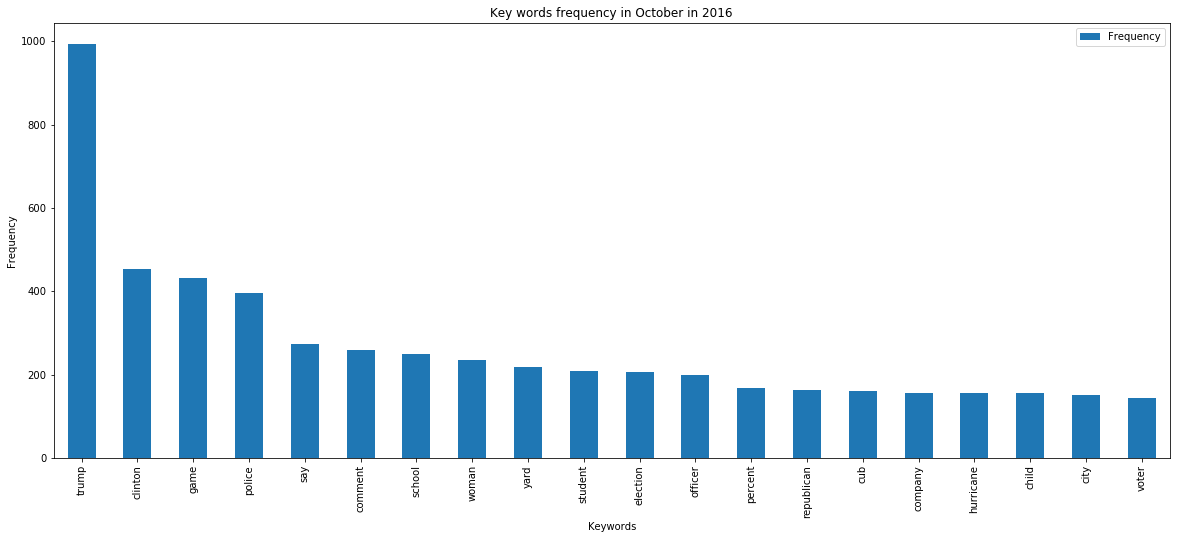

In [618]:
# plot the bar chart to illustrate the top-20 keywords
key_words_top20.plot(kind='bar')
plt.title('Key words frequency in October in 2016')
plt.ylabel('Frequency')
plt.xlabel('Keywords')
plt.show()

### Discovery:
After our tfidf analysis, we could find out that in the month rightly before American Precidental Election held on 8th November 2016, many pieces of news are highly related to the presidential election.

Later, we chose 'trump' as the selected topic to further dig up the media polarity considering time variance.

In [626]:
# get the news id whose keywords contains 'trump'
trump_list = [ind_list[i] for i in range(num_doc) if 'trump' in tfidf_top5_key[i]]

In [216]:
# save the news list in pickle
with open('trump_list.pickle', 'wb') as w:
    pickle.dump(trump_list, w)

### Part3: Get Original Data from Website

Considering some missing original text in our data, we further applied the methodology of web crawling from the websites provided in our dataset. We will developed more application this part in the future.

In [627]:
# remove the extra space and tag (such as <p>) in the raw text
tags_re = re.compile(r'(\<.*\>|\s+)')

In [642]:
def HTMLGetandParser(url):
    """
        Aimed to get the information based URL, and parse and select the data according to HTML
        input: url
        output: txt
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    paragraph = soup.p
    txt = ''
    
    while paragraph:
        txt += (tags_re.sub(' ', str(paragraph)) if len(str(paragraph)) > 100 else '')
        paragraph = paragraph.next
    return txt

In [643]:
web_pd = data_US_16_10_sorted.iloc[:100]['website'].apply(lambda url: HTMLGetandParser(url))

In [644]:
# show web pd
web_pd.head()

304572     Cloudy with occasional showers overnight. Low...
304573      Play Now   Play Now              Play Now   ...
304574     We use cookies and other tracking technologie...
304575        #weather-1273331 .list-unstyled { margin:0...
304576     Your user agent has been blocked from this si...
Name: website, dtype: object

### Part4: Conduct Sentimental Analysis

##### 4.1 Helper functions

In [366]:
def sentiment_TextBlob(text,pos_threshold = 0.3,neg_threshold = -0.3):
    """
    Get polarity of text by mean of polarity of each sentence
    Since most sentences convey nothing in an article, we decide to eliminate neutral sentence
    and only take polar sentence into account
    If there is no polar sentence in an article, return 0
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    """
    # Get blob
    blob = TextBlob(text)
    
    # Get sentence objs
    sentences = blob.sentences
    
    # Get sentence polarity
    polarity = list(map(lambda x: 1 if x.sentiment[0] > pos_threshold \
                                    else (-1 if x.sentiment[0] < neg_threshold \
                                             else 0),
                      sentences))
    
    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == 0):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [367]:
def sentiment_nltk(text,pos_threshold = 0.3,neg_threshold = -0.3):
    '''
    Get polarity of article using nltk
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    Return: polarity
    '''
    
    # Get sentences
    sentences=nltk.sent_tokenize(text)
    
    # Get polarity analyzer
    sid = SentimentIntensityAnalyzer()

    # Calculate scores and polarity of sentences
    scores = list(map(lambda x: sid.polarity_scores(x)['compound'], sentences))
    polarity = list(map(lambda x: 1 if x > pos_threshold \
                                       else (-1 if x < neg_threshold \
                                            else 0),
                       scores))

    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == [0]):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [368]:
def find_polarity_tags(articles):
    '''
    Return polarity for articles using mean of nltk and textblob
    Params: articles: Array(str)
    Return: tags
    '''
    
    polarity_articles = list(map(lambda x: np.mean([sentiment_TextBlob(x),
                                                   sentiment_nltk(x)]),
                               articles))
    
    return polarity_articles


##### 4.2 Explore on Media Polarity about 'trump' on October 2016

In [280]:
# Obtain list of index of news with keyword Trump
Trump_list=pd.read_pickle('trump_list.pickle')

In [284]:
# Obtain dataframe of news with keyword Trump
mask = data_US_16_10['id'].isin(Trump_list)
data_Trump = data_US_16_10_sorted.loc[mask]

In [435]:
# Convert index of txt_pd to int type
txt_pd.index = txt_pd.index.astype(int)

In [307]:
# Get news focus on Trump by merging the related ids with news df
Trump_news_16_10 = data_Trump.merge(txt_pd, left_on='id', right_index = True)

In [439]:
# Show the news focused on Trump
Trump_news_16_10.head()

,id,unknown,date,country,media,website,title,year,month,day,index,txt,index_str,index_int,tag
0,14642538,887,16-10-01,US,The State,http://www.thestate.com/news/politics-governme...,Horry County voters reflect frustration of Tru...,16,10,01,14642538,Lucy Cesar-Jedacek walked into the Horry Cou...,14642538,14642538,0.536797
1,14645950,266,16-10-01,US,Entertainment Weekly,http://www.ew.com/article/2016/10/01/art-deal-...,The Art of the Deal ghostwriter claims Donald ...,16,10,01,14645950,"See also Tony Schwartz , the ghostwriter wh...",14645950,14645950,-0.166667
2,14645980,833,16-10-01,US,The Seattle Times,http://www.seattletimes.com/opinion/the-death-...,The death of idealism,16,10,01,14645980,The death of idealism Share story This pre...,14645980,14645980,0.520690
3,14645984,4345,16-10-01,US,Outside the Beltway,http://www.outsidethebeltway.com/on-the-potent...,On the Potential Global Consequences of a Trum...,16,10,01,14645984,On the Potential Global Consequences of a Tr...,14645984,14645984,0.041190
4,14647956,4657,16-10-01,US,Chicago Tribune,http://www.chicagotribune.com/news/nationworld...,The journey of a Trump true believer: 'Finally...,16,10,01,14647956,The journey of a Trump true believer : ' Fin...,14647956,14647956,0.318484


In [443]:
# Find polarity of news 
Trump_news_16_10['polarity'] = find_polarity_tags(Trump_news_16_10['txt'])

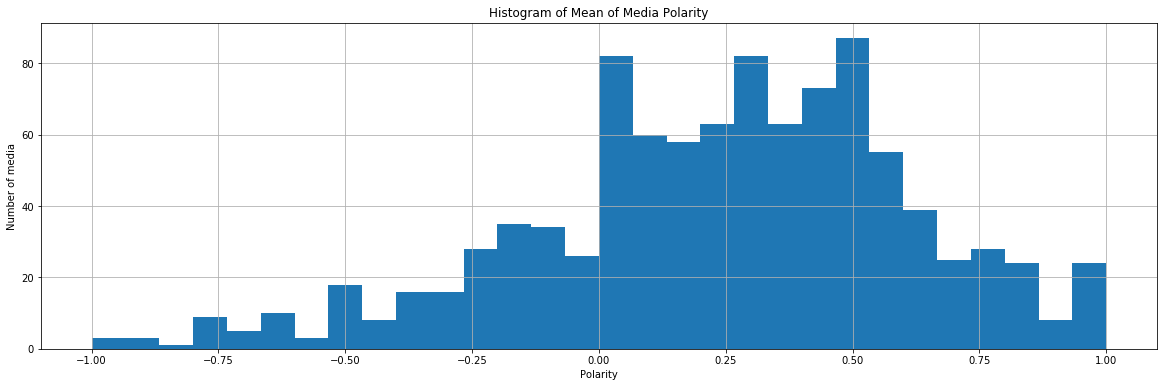

In [480]:
# Visualize the polarity
Trump_news_16_10['polarity'].hist(bins=30, grid=True)
plt.title('Histogram of Mean of Media Polarity')
plt.xlabel('Polarity')
plt.ylabel('Number of media')
plt.show()

In [472]:
# collect polarity of news from same media
Trump_media = Trump_news_16_10.groupby('media')['polarity'].apply(np.array)

It is not representative to investigate into the media that have few pieces of news about Trump. By trial and error we select 12 as a threshold for selecting representative media.

In [473]:
Trump_media = Trump_media.to_frame()

Trump_media_top = Trump_media[Trump_media['polarity'].apply(lambda x: len(x)) > 12].copy()

Considering there exists the offset during sentimental analysis, we decided to normalize the data (subtract the mean of all of the polarities) in order to have a better understanding on our dataset.

In [474]:
# Get universal mean of polarity of representative news
media_count = Trump_media_top['polarity'].apply(len)

media_mean = tmp['tag'].apply(np.mean)

mean_polarity = np.sum(media_count * media_mean) / np.sum(media_count)

In [475]:
# Normalize the polarity
Trump_media_top['normalized_polarity'] = Trump_media_top['polarity'] - mean_polarity

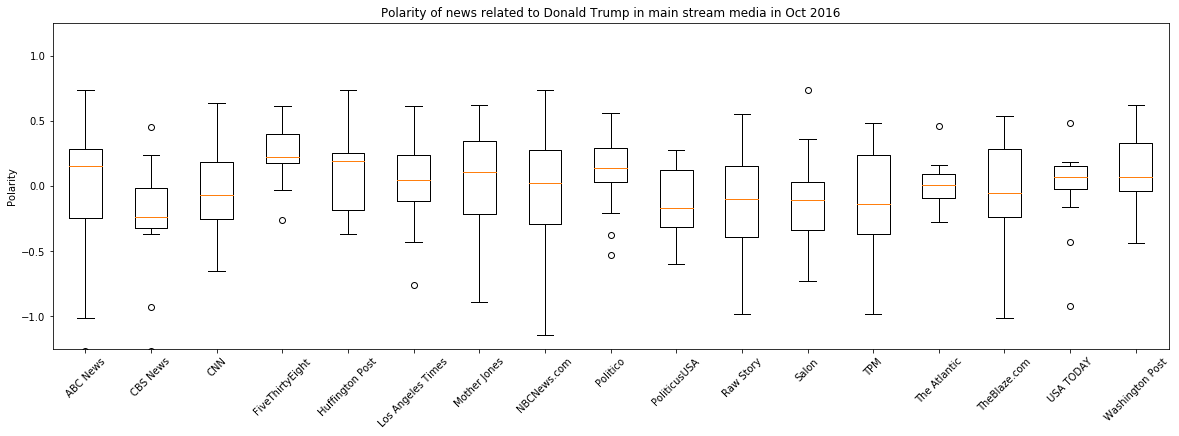

In [481]:
# Visualize the polarity of media
data = Trump_media_top['normalized_polarity'].values

index = Trump_media_top.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in Oct 2016')
plt.show()

In [482]:
# Store data for further usage
Trump_news_16_10.to_pickle('Trump_news_16_10_polar.pickle')

##### 4.3 Explore the time variance of media polarity

By repeating the same manipulation scheme, we obtain the data for Aug and Sept of 2016. For simplicity, here we just load those data in and conduct analysis. The functionalities will be finely encapusulated in the next step to provide better scalability.

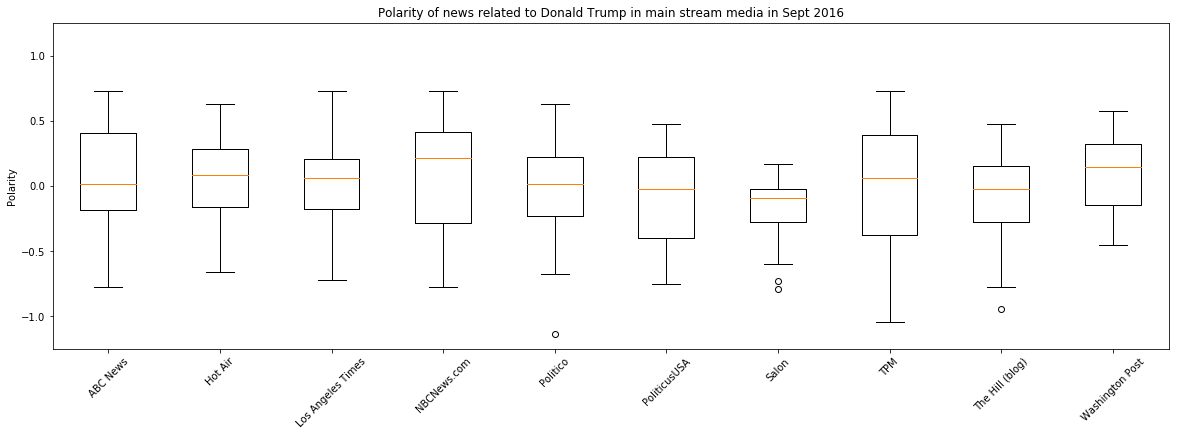

In [498]:
# Comparisons
Trump_media_top_sept = pd.read_pickle('Trump_media_top_Sept.pkl')

# Visualize the polarity of media in Sept
data = Trump_media_top_sept['normalized_polarity'].values

index = Trump_media_top_sept.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in Sept 2016')
plt.show()

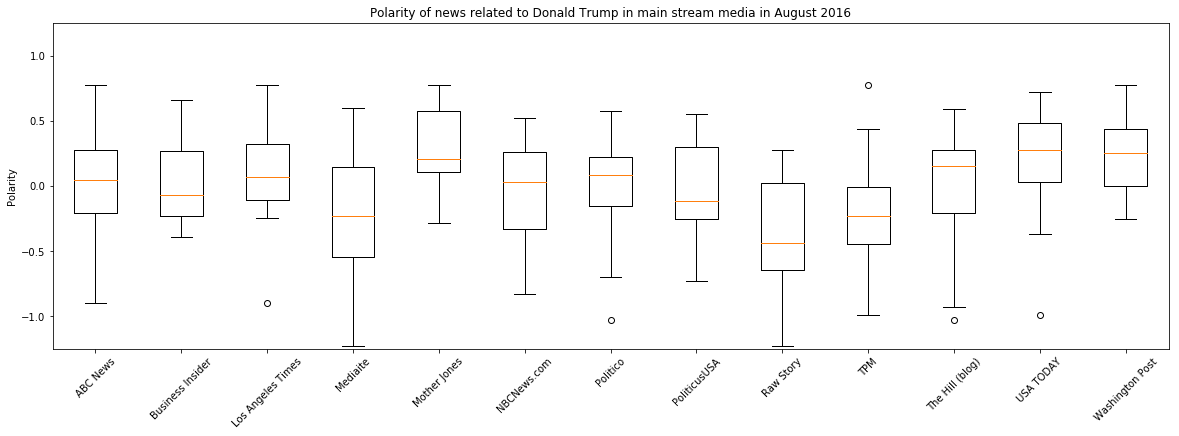

In [497]:
# Comparisons
Trump_media_top_aug = pd.read_pickle('Trump_media_top_Aug.pkl')

# Visualize the polarity of media in August
data = Trump_media_top_aug['normalized_polarity'].values

index = Trump_media_top_sept.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in August 2016')
plt.show()

In [629]:
# Visualize the attitude change of media during three months

media_intersection = set(Trump_media_top.index)\
                        .intersection(set(Trump_media_top_sept.index))\
                        .intersection(set(Trump_media_top_aug.index))

Media that are continuosly interested in Trump over three months

In [630]:
media_intersection = pd.DataFrame(list(media_intersection))

In [631]:
media_intersection.columns = ['media']

In [632]:
# show median_intersection
media_intersection

,media
0,TPM
1,Los Angeles Times
2,PoliticusUSA
3,ABC News
4,Politico
5,NBCNews.com
6,Washington Post


In [633]:
# Get the normalized polarity of media in intersection
media_intersection_polarity = media_intersection.merge(Trump_media_top, left_on = 'media', right_index = True)\
                                                .merge(Trump_media_top_sept, left_on = 'media', right_index = True,
                                                      suffixes = ('_Oct', '_Sept'))\
                                                .merge(Trump_media_top_aug, left_on = 'media', right_index = True)

In [634]:
# rename the columns to meaningful name
media_intersection_polarity.rename(columns = dict(polarity = 'polarity_Aug',
                                             normalized_polarity = 'normalized_polarity_Aug'), inplace = True)
media_intersection_polarity.set_index(keys = ['media'], inplace = True)

In [635]:
# show the media polarity
media_intersection_polarity

,polarity_Oct,normalized_polarity_Oct,normalized_polarity_Sept,polarity_Sept,normalized_polarity_Aug,polarity_Aug
media,,,,,,
TPM,"[-0.7142857142857143, -0.30952380952380953, 0....","[-0.9787842654487224, -0.5740223606868176, 0.2...","[-0.37487579077512556, 0.7251242092248744, 0.5...","[-0.1, 1.0, 0.8571428571428572, 0.666666666666...","[0.17275415386064777, 0.022754153860647747, -0...","[0.4, 0.25, -0.20833333333333334, -0.166666666..."
Los Angeles Times,"[0.41666666666666663, 0.5, -0.1666666666666666...","[0.15216811550365855, 0.23550144883699192, -0....","[-0.17487579077512552, 0.18666267076333604, 0....","[0.1, 0.46153846153846156, 0.5608465608465608,...","[-0.07605221218709762, 0.3609894479782948, -0....","[0.15119363395225463, 0.5882352941176471, 0.10..."
PoliticusUSA,"[-0.26666666666666666, -0.1, 0.504273504273504...","[-0.5311652178296747, -0.3644985511630081, 0.2...","[-0.5748757907751255, -0.024875790775125528, 0...","[-0.3, 0.25, 0.5, 0.22916666666666666, -0.4747...","[0.487039868146362, -0.11613473502824115, -0.2...","[0.7142857142857143, 0.1111111111111111, -0.07..."
ABC News,"[0.45454545454545453, 0.5555555555555556, 0.75...","[0.19004690338244645, 0.2910570043925475, 0.48...","[-0.5665424574417921, 0.30845754255820784, 0.0...","[-0.29166666666666663, 0.5833333333333334, 0.3...","[0.2727541538606477, 0.12275415386064772, -0.5...","[0.5, 0.35, -0.3333333333333333, 0.03333333333..."
Politico,"[0.4, 0.33333333333333337, 0.2879310344827586,...","[0.13550144883699194, 0.06883478217032529, 0.0...","[-0.5248757907751256, 0.10973959384025905, 0.6...","[-0.25, 0.3846153846153846, 0.9, 0.57142857142...","[0.22355506919245552, 0.028114777642324146, -0...","[0.45080091533180777, 0.2553606237816764, -0.1..."
NBCNews.com,"[0.3055555555555556, 0.27058823529411763, 0.13...","[0.0410570043925475, 0.006089684131109552, -0....","[0.46512420922487446, 0.30845754255820784, -0....","[0.74, 0.5833333333333334, 0.10666666666666666...","[-0.26724584613935226, 0.07527516226400907, -0...","[-0.04000000000000001, 0.3025210084033613, -0...."
Washington Post,"[0.3015873015873016, 0.3802008608321377, 0.625...","[0.03708875042429355, 0.11570230966912964, 0.3...","[-0.2034472193465541, -0.12580746779375906, -0...","[0.07142857142857142, 0.14906832298136646, 0.2...","[-0.18538538102307317, -0.0017023678784826857,...","[0.041860465116279076, 0.22554347826086957, 0...."


In [637]:
# Find mean for each cell
media_intersection_polarity = media_intersection_polarity.applymap(np.mean)

In [638]:
# show polarity after mean calculation
media_intersection_polarity

,polarity_Oct,normalized_polarity_Oct,normalized_polarity_Sept,polarity_Sept,normalized_polarity_Aug,polarity_Aug
media,,,,,,
TPM,0.127434,-0.137065,-0.009872,0.265004,-0.215731,0.011515
Los Angeles Times,0.310189,0.045690,-0.016708,0.258168,0.080395,0.307641
PoliticusUSA,0.136290,-0.128208,-0.077470,0.197406,-0.003161,0.224085
ABC News,0.257565,-0.006934,0.038081,0.312957,-0.000394,0.226852
Politico,0.400635,0.136136,-0.055315,0.219560,-0.019178,0.208068
NBCNews.com,0.219658,-0.044840,0.076774,0.351650,-0.081730,0.145515
Washington Post,0.379463,0.114964,0.103932,0.378808,0.219542,0.446787


In [639]:
# clean the dataframe and drop the useless columns
media_intersection_polarity.drop(labels = ['polarity_Oct', 'polarity_Sept', 'polarity_Aug'],
                                 axis = 1,
                                 inplace = True)

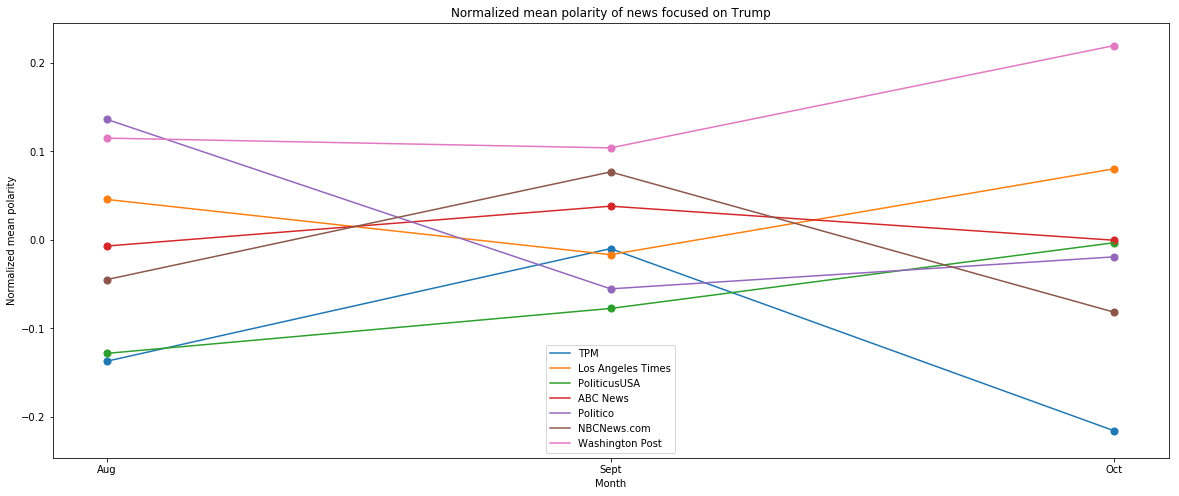

In [640]:
# plot the polarity of popular medias based on the topic of 'trump' in August, September, October 2016
keys = ['normalized_polarity_Aug', 'normalized_polarity_Sept', 'normalized_polarity_Oct']
medias = media_intersection_polarity.index
plt.rcParams['figure.figsize'] = (20, 8)
for media in medias:
    plt.scatter(x = np.arange(len(keys)),
               y = media_intersection_polarity.loc[media],
               s = 50)
    plt.plot(np.arange(len(keys)),
            media_intersection_polarity.loc[media])
plt.legend(medias, loc = 'best')
plt.xticks(np.arange(len(keys)), ['Aug', 'Sept', 'Oct'])
plt.xlabel('Month')
plt.ylabel('Normalized mean polarity')
plt.title('Normalized mean polarity of news focused on Trump')
plt.show()

## MileStone Conclusion:
During this milestone, we collected and preprocessed the data, tried our proposed methods on test part, got some progressive development, and obtained some inspiration from the difficulties. We firstly focused on media reaction on the topic of trump in October 2016, and extended to time domain, as proposed in milestone. Basically speaking, referring to some controversial topics, there indeed exists media porlarity, based on our three-month US news analysis before 2016 presidental election. We would like to go further till the next milestone.

In the following, we show some difficulties we met during this milestone, and some expectation of milestone3.

## Discussion
## The problems we encountered during working on milestone2
### A. Select Topic
We choose the top 5 keywords to select the topic without any priority. Therefore, sometimes these 5 keywords may not be related to each other. We might choose relative keywords from the most frequent keywords in the future work.
### B. Get Original Data from Website
When we try to get the content of the news, sometimes we will also get some irrelevant data. We need to find an efficient way to get only the data we want.
### C. Conduct Sentimental Analysis
Now we use sentiment analyzer module of NLTK and TextBlob to analyse the polarity of each sentence in an article. And we set positive threshold and negative threshold to classify the polarity of the sentences. By calculating the percentage of sentences with different polarities, we determine the polarity of the whole article. 

One of the problems is that some of the content of the news might be irrelevant to the topic (e.g., Thank you for your reading) because of the incorrect data extraction. And this irrelevant sentences might have a very high or low polarity score, which has a bad influence on our results. Our solution is that we subtract the median polarity score from the mean score to avoid the bias.

### Part5: Build up Our Classifier

#### Todo:
1. Build up our own classifier using some Machine Learning methodologies, such as Naive Bayes Classifier, to determine the polarity of the news more reasonably based on the results of NLTK and TextBlob.
2. Backup Solution: If the performance of the classifier is not satisfactory, we will still use NLTK and TextBlob but switch from document-wise to sentence-wise. For example, 'the weather is good.' and 'The policy is good.' might have the same score but the second sentence is more important in political topics obviously. So we can assign different weights for the sentences according to the relation to the topic (e.g. sentences with keywords).

In [647]:
# On the way

### Part6: Enlarge the Dataset

#### Todo:
1. Process more data from the dataset to analyze the polarity of medias as the requirement of more medias, more topcs and larger time range.
2. In this part, we will apply Spark to meet our demands.

In [648]:
# On the way

### Part7: Explore in Other Topics

#### Todo:
1. According to the keywords, select the topics with strong relation.
2. Follow the same steps in above parts to analyze the polarity of the medias in different but relative topics. For example, we will find out how the polarity scores of the medias change over time in a set of topics, such as election, immigration and Trump. We can compare the trend in different topics with strong and week relation.

In [649]:
# On the way

### Part8: Conclusion

By summarizing the polarity of the medias in different topics over time, we can find out the potential polarity of the medias. For example, if a media have a positive view on some social topics like education, economy and policy, this media might have the same polarity in relative topics like election.

In [650]:
# On the way